<a class="anchor" id="123"></a>
<h1 style="text-align:center;">Numerical Analysis: Project III - Interpolation<h1/>
<h5>
    <p style="text-align:center;">Michał Wilk 180333<p/>
    <p style="text-align:center;">05-2021<p/>
<h5/>
   
---

## Table of Contents <a class="anchor" id="-1"></a>

---

#### 0) [Installation](#0)
#### 1) [Data samples](#1)
#### 2) [Laplace interpolation method](#2)
#### 3) [Cubic spline interpolation method](#3)
#### 4) [Testing on small example](#4)
#### 5) [Samples locations](#5)
#### 6) [Presentation: even distribution](#6)
#### 7) [Conclusions I](#7)
#### 8) [Presentation: uneven distribution](#8)
#### 9) [Conclusions II](#9)

### Installation
---

Dependancies:
* pandas
* matplotlib
* numpy
* ipyleaflet
* ipywidgets

<br/>

Install required dependancies
```bash
pip install -r requirements.txt
```

Or create virtual environment inside the project directory
```bash
pip install pipenv
pipenv install
```

<br/>

Enabling widgets addons _(you can skip this step, because it will be performed
automatically)_
```bash
jupyter nbextension enable --py widgetsnbextension

jupyter nbextension install ipyleaflet --user --py
jupyter nbextension enable ipyleaflet --user --py
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
plt.style.use("fivethirtyeight")

#### Widget configuration part

In [2]:
# !pip install ipywidgets ipyleaflet

# I highly advise running below command to enable interactive sliders
# and maps !!
# This way the notebook is much better looking and more
# enjoyfull to use
!jupyter nbextension enable --py widgetsnbextension &> /dev/null

!jupyter nbextension install ipyleaflet --user --py &> /dev/null
!jupyter nbextension enable ipyleaflet --user --py &> /dev/null

In [3]:
from ipywidgets import interact, IntSlider
from ipyleaflet import Map, basemaps

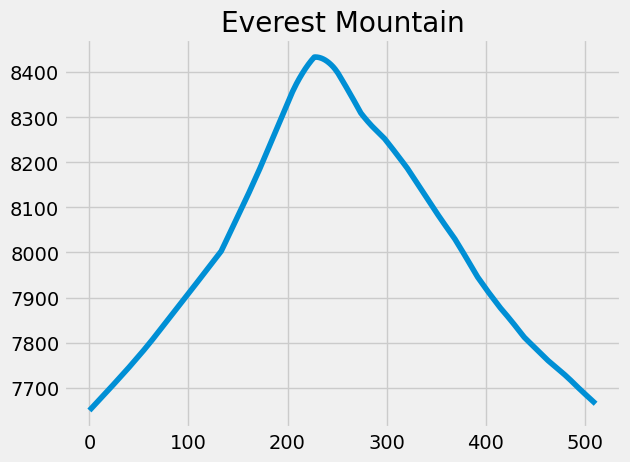

In [4]:
greece = pd.read_csv("data/greece.csv")
kilimanjaro = pd.read_csv("data/kilimanjaro.csv")
dead_sea = pd.read_csv("data/dead_sea.csv")
everest = pd.read_csv("data/everest.csv")

everest.iloc[:,1].plot(title="Everest Mountain")
plt.show()

### 1) Data Samples <a class="anchor" id="1"></a>
---
_Small presentation of the datasets_

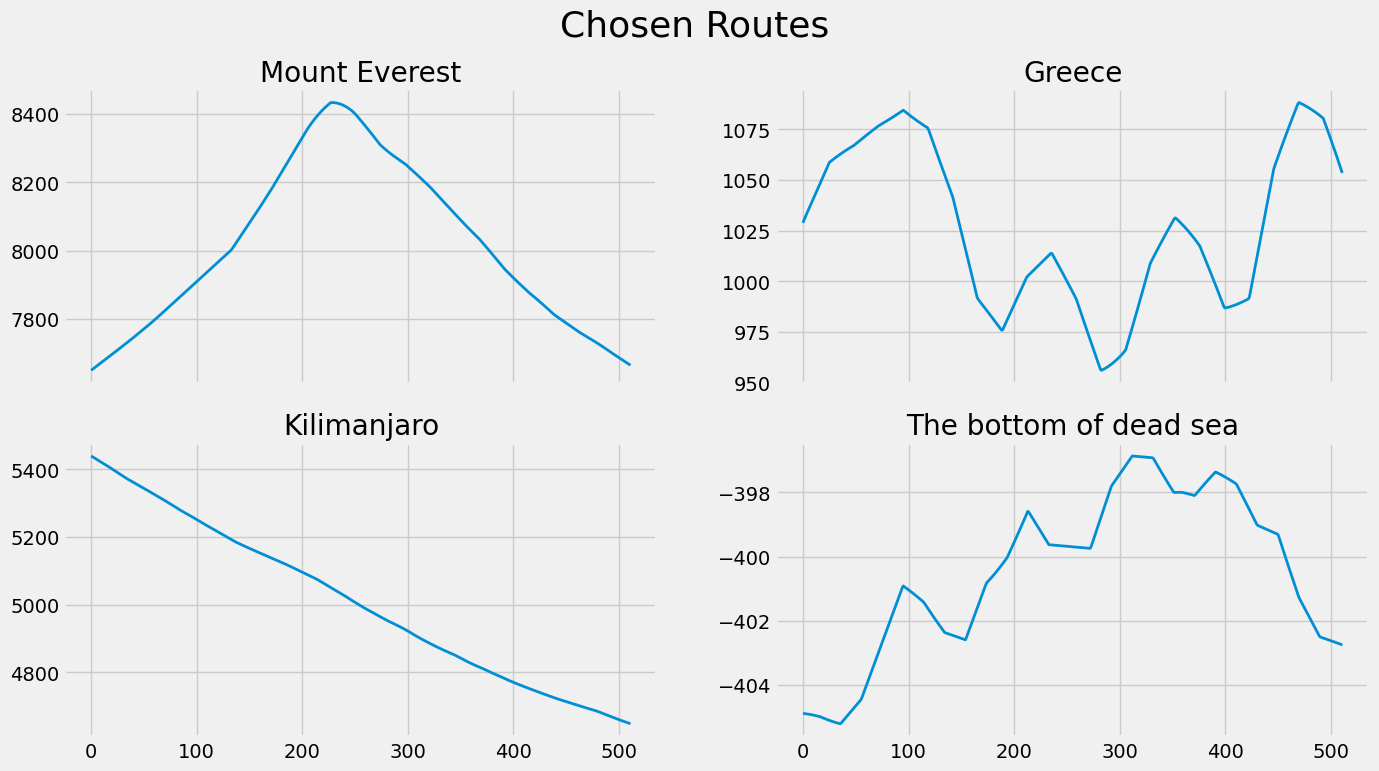

In [5]:
fig, ax = plt.subplots(2, 2, sharex='col', figsize=(15,8))
fig.suptitle("Chosen Routes", fontsize=26)

ax[0,0].plot(everest.iloc[:,1], linewidth=2)
ax[0,1].plot(greece.iloc[:,1], linewidth=2)
ax[1,0].plot(kilimanjaro.iloc[:,1],linewidth=2)
ax[1,1].plot(dead_sea.iloc[:,1], linewidth=2)

ax[0,0].set_title("Mount Everest")
ax[0,1].set_title("Greece")
ax[1,0].set_title("Kilimanjaro")
ax[1,1].set_title("The bottom of dead sea")
plt.show()

### 2) Laplace interpolation method <a class="anchor" id="2"></a>
---
_Implementation of the laplace interpolation method_

In [6]:
def create_poly(xs:np.ndarray, const_mul, x_value, x_idx):
    n = xs.shape[0]
    
    # declaring a denominator which is a constant
    product = np.prod([x_value - xs[i] for i in range(n) if i != x_idx])
    if product == 0:
        denom = 1000_000
    else:
        denom = 1 / product
    
    # creating coefficients from given roots
    coeffs = np.poly([xs[i] for i in range(n) if i != x_idx])
    
    # declaring the polynomial at the top of the equation
    polyn = np.poly1d(coeffs)
    return lambda x: polyn(x) * denom * const_mul

def lagrange_interpolation(xs:np.ndarray, ys:np.ndarray):
    """
    Returns a function which is interpolated representation
    of the original function
    """
    assert xs.shape == ys.shape, "You must declare data with equal sample size!"
    n = xs.shape[0]
    
    # Constructing polynomials
    polly = [create_poly(xs, ys[i], xs[i], i) for i in range(n)]
    
    # Creating interpolated representation of function
    result = lambda x: sum([p(x) for p in polly])
    return result

### 3) Cubic Spline interpolation method <a class="anchor" id="3"></a>
---
_Implementation of the cubic spline method_

In [7]:
# import scipy.linalg as la # only for testing purposes

def lu_decompose(M):
    assert M.shape[0] == M.shape[1]
    m = M.shape[0]
    L = np.identity(m)
    U = np.copy(M).astype(float) # 5 hours of work in one line...
    P = np.eye(m) # permutations
    
    for k in range(m-1):
        # pivoting
        idx = np.argmax(abs(U[k:m,k])) + k
        
        U[[k, idx], k:m] = U[[idx, k], k:m]
        L[[k, idx], :k] = L[[idx, k], :k]
        P[[k, idx], :] = P[[idx, k], :]
        assert U[k][k] != 0, "cannot divide by zero!!"
        
        factor = U[k+1:, k] / U[k, k]
        L[k+1:, k] = factor
        U[k+1:] -= factor[:, np.newaxis] * U[k]
        
    return L, U, P

def back_sub(U, y):
    n = U.shape[0]
    x = np.zeros_like(y, dtype=np.double);
    x[-1] = y[-1] / U[-1, -1]
    
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - np.dot(U[i,i:], x[i:])) / U[i,i]
        
    return x

def forward_sub(L, b):
    n = L.shape[0]
    y = np.zeros_like(b, dtype=np.double)
    y[0] = b[0] / L[0,0]
    for i in range(1, n):
        y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
    return y

def lu_solve(A, b):
    L, U, P = lu_decompose(A)
    b = P @ b
    y = forward_sub(L, b)
    x = back_sub(U, y)
    return x

example = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 4, 2, 1],
    [3, 2, 1, 0, -3, -2, -1, 0], 
    [6, 2, 0, 0, -6, -2, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 12, 2, 0, 0]
 ])

b = np.array([1, 3, 3, 2, 0, 0, 0, 0])

print(f"Correct: {np.linalg.solve(example, b)}") # only for comparison
print(f"My solution {lu_solve(example, b)}" )

Correct: [-0.75  0.    2.75  1.    0.75 -4.5   7.25 -0.5 ]
My solution [-0.75  0.    2.75  1.    0.75 -4.5   7.25 -0.5 ]


In [8]:
def get_interval(x0, x1, x2, y0, y1, y2):
    assert x0 != x1 != x2, "You cannot create function from repeating base points"
    A = np.array([
        [x0**3, x0**2, x0, 1, 0, 0, 0, 0], # x0 = 0
        [0, 0, 0, 0, x1**3, x1**2, x1, 1], # x1 = 1
        [x1**3, x1**2, x1, 1, 0, 0, 0, 0], # x1 = 1
        [0, 0, 0, 0, x2**3, x2**2, x2, 1], # x2 = 2
        [3*x1**2, 2*x1, 1, 0, -3*x1**2, -2*x1, -1, 0], # first derivative
        [6*x1, 2, 0, 0, -6*x1, -2, 0, 0], # second derivative
        [6*x0, 2, 0, 0, 0, 0, 0, 0], # left edge
        [0, 0, 0, 0, 6*x2, 2, 0, 0], # right edge
    ])

    b = np.array([y0, y1, y1, y2, 0, 0, 0, 0])
    b = np.vstack(b)
#     x = np.linalg.solve(A.astype(float), b.astype(float))
    x = lu_solve(A.astype(float), b.astype(float))
    a0, b0, c0, d0, a1, b1, c1, d1 = np.hstack(x)
    poly1 = np.poly1d([a0, b0, c0, d0])
    poly2 = np.poly1d([a1, b1, c1, d1])
    
    return poly1, poly2

def spline_interpolation(xs:np.ndarray, ys:np.ndarray):
    assert xs.shape == ys.shape, "You must declare data with equal sample size!"
    assert xs.shape[0] >= 3, "To perform interpolation you must provide at least 3 values"
    assert (xs.shape[0] - 1) % 2 == 0, "You must provide correct "\
        f"amount of samples to be sliced. Provided: {xs.shape[0]}"
    
    n = xs.shape[0]
    buckets = []
    
    for i in range(0,n-1,2):
        itrs = get_interval(xs[i], xs[i+1], xs[i+2], ys[i], ys[i+1], ys[i+2])
        buckets.extend(itrs)
        
    def analitic_func(x):
        assert x >= xs[0] and x <= xs[-1], (f"The value {x} must "
                                            f"exist in declared scope {xs[0]}, {xs[-1]}")
        chosen = ((x-xs[0]) / (xs[-1] - xs[0])) * len(buckets)
        
        if chosen == len(buckets): chosen = -1
        else: chosen = np.floor(chosen).astype(int)
        return buckets[chosen](x)
    return analitic_func

### 4) Testing on small example <a class="anchor" id="4"></a>
---
Now we will find out how each method work on small sample data:

Everest route with 7 equally distant points.

#### 4.1) Lagrange interpolation method

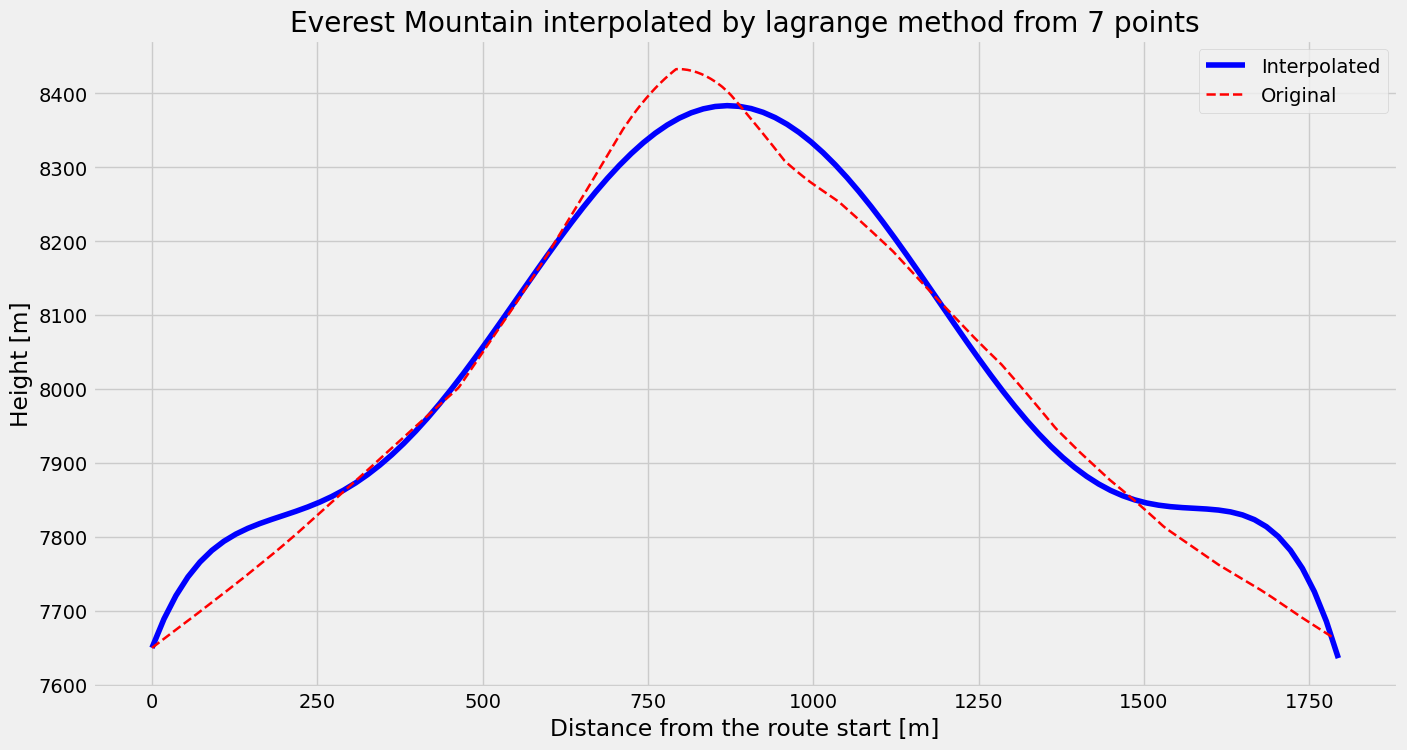

In [9]:
number_of_polynomials = 7

size = len(everest.iloc[:,1])
idxs = np.linspace(0, size-1, num=number_of_polynomials, dtype=int)
y = np.array(everest.iloc[idxs,1])
x = np.array(everest.iloc[idxs,0])

ff = lagrange_interpolation(x, y)

pp = np.linspace(0, everest.iloc[-1,0] + 10, num=100)
plt.figure(figsize=(15,8))
plt.plot(pp, [ff(i) for i in pp], "b", label="Interpolated")
plt.plot(everest.iloc[:,0], everest.iloc[:,1], "r--", label="Original", linewidth=1.8)
plt.legend()
plt.title("Everest Mountain interpolated by lagrange "
          f"method from {number_of_polynomials} points")
plt.xlabel("Distance from the route start [m]")
plt.ylabel("Height [m]")
plt.show()

#### 4.2) Cubic spline interpolation method

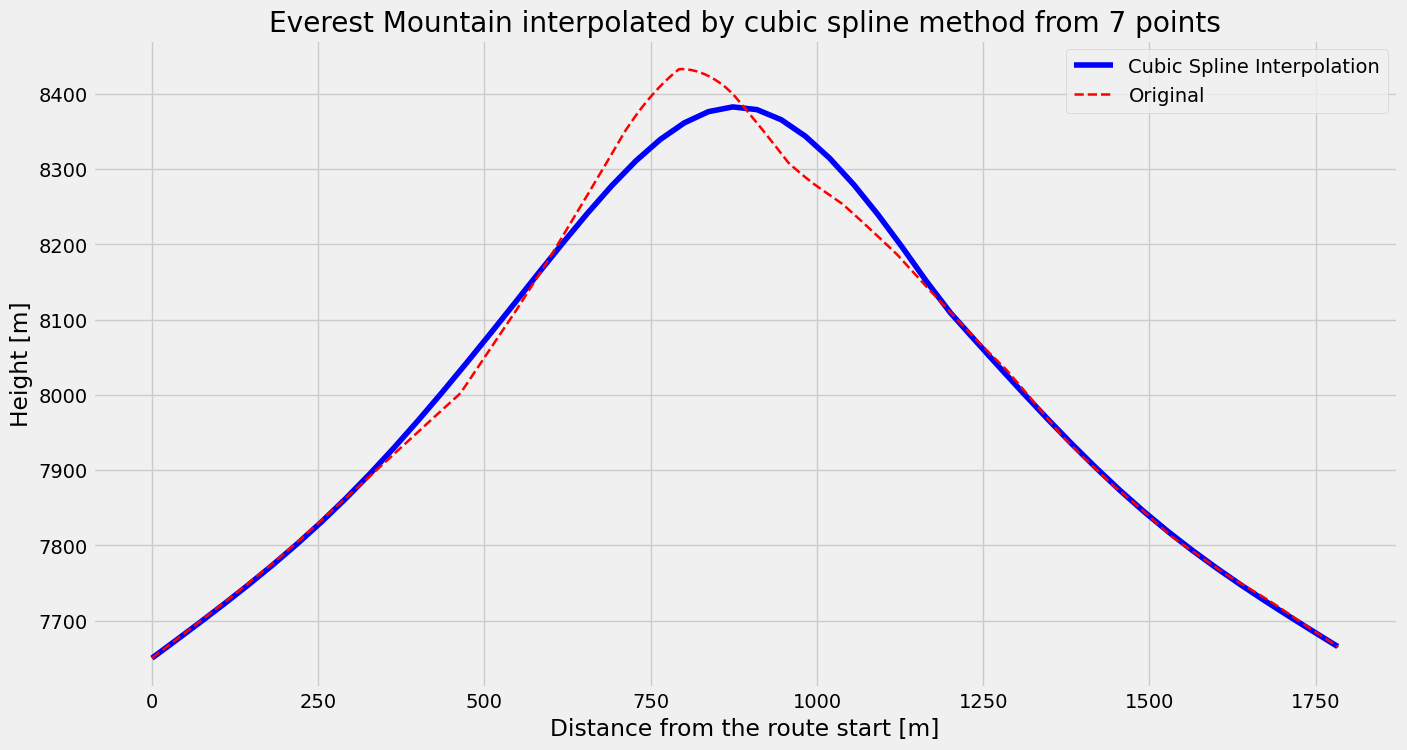

In [10]:
number_of_polynomials = 7

size = len(everest.iloc[:,1])
idxs = np.linspace(0, size-1, num=number_of_polynomials, dtype=int)
y = np.array(everest.iloc[idxs,1])
x = np.array(everest.iloc[idxs,0])
ff = spline_interpolation(x, y)

pp = np.linspace(0,everest.iloc[-1,0]-1)
plt.figure(figsize=(15,8))
plt.plot(pp, [ff(i) for i in pp], "b", label="Cubic Spline Interpolation")
plt.plot(everest.iloc[:,0], everest.iloc[:,1], "r--", label="Original",linewidth=1.8)
plt.legend()
plt.title("Everest Mountain interpolated by cubic spline "
          f"method from {number_of_polynomials} points")
plt.xlabel("Distance from the route start [m]")
plt.ylabel("Height [m]")
plt.show()

Both method seems to be implemented correctly and yielded functions roughly represent original data.

### 5) Interpolating diffrent datasets <a class="anchor" id="5"></a>
Now that we know that the implementation is correct, we will test our methods on diffrent
types of data and diffrent quantities of
points.

---
<br/>

__Prepared data:__
* one steep hill - ridge of the Everest mountain
* mild one sided slope - slope of the mountain Killimanjaro
* flat surface - the coast of the dead sea
* many steep hills - mountains in greece

<br/>
<br/>

You can see diffrent routes presented on the map widget below

In [11]:
def get_dataset(name):
    if name == "Everest Mountain":
        return everest
    elif name == "Greece Hills":
        return greece
    elif name == "Slope of the Kilimanjaro mountain":
        return kilimanjaro
    elif name == "Coast of the Dead Sea":
        return dead_sea
    else: assert False
        
def get_distribution(name, start, end, num):
    if name is None or name == "even":
        return np.linspace(start, end, num=num, dtype=int)
    elif name == "uniform":
        arr = np.random.randint(start, end, num)
    elif name == "normal":
        centre = (end - start) / 2 + start
        width = (end - start) / 4 - 1
        arr = np.random.normal(centre, width, num).astype(int)
    elif name == "laplace":
        centre = (end - start) / 2 + start
        arr = np.random.normal(centre, (end - start) / 2, num).astype(int)
    else: assert False
    
    arr = arr[np.where((arr >= start) & (arr < end))[0]]
    arr.sort()
    arr = np.unique(arr)
    if arr.shape[0] % 2 == 0:
        arr = arr[:-1]
    return arr

In [12]:
from ipyleaflet import Map, Marker, MarkerCluster, AntPath
from functools import lru_cache

routes = [
    "Everest Mountain",
    "Greece Hills",
    "Slope of the Kilimanjaro mountain",
    "Coast of the Dead Sea"
]
zoom = 14
num_of_markers = 20

@interact(route = routes)
@lru_cache # by doing this we enable map editing and improving overall performance
def display_routes(route):
    dataset = get_dataset(route)
    center = [dataset.iloc[dataset.shape[0]//2 ,2], dataset.iloc[dataset.shape[0]//2,3]]
    marker_idxs = np.linspace(0, dataset.shape[0]-1, num=num_of_markers).astype(int)
    points = [(dataset.iloc[i,2],dataset.iloc[i,3]) for i in marker_idxs]
    start_marker = Marker(location=(dataset.iloc[0,2], dataset.iloc[0,3]))
    finish_marker = Marker(location=(dataset.iloc[-1,2], dataset.iloc[-1,3]))
    
    ant_path = AntPath(
        locations=points,
        dash_array=[1, 10],
        delay=1000,
        color='#7590ba',
        pulse_color='#3f6fba'
    )
    m = Map(basemap=basemaps.OpenTopoMap, center=center, zoom=zoom)
    m.add_layer(ant_path)
    m.add_layer(start_marker)
    m.add_layer(finish_marker)
    return m
    

interactive(children=(Dropdown(description='route', options=('Everest Mountain', 'Greece Hills', 'Slope of the…

In [13]:
from typing import Callable, Tuple

"""
I am caching each function to improve overall performance. In downside
this means that each result (interpolations) needs to be stored in RAM 
(all results combined take about 1 Gb of RAM). 
If you really care about the RAM usage, then remove below line.
"""
@lru_cache
def generate_interpolation(
        route, 
        points, 
        method, 
        distribution=None,
        start:float=0.0,
        end:float=1.0
) -> Tuple[Callable, pd.DataFrame, np.ndarray]:
    dataset = get_dataset(route)
    size = len(dataset.iloc[:,1])
    assert start < end, "Start must exist before the end"
    
    idxs = get_distribution(
        distribution, 
        int(size*start),
        int(size*end-1),
        points
    )
    y = np.array(dataset.iloc[idxs,1])
    x = np.array(dataset.iloc[idxs,0])
    
    if method == "Lagrange":
        return lagrange_interpolation(x, y), dataset, idxs
    elif method == "Cubic Spline":
        return spline_interpolation(x, y), dataset, idxs
    else: assert False

### 6) Interactive interpolation widget (even distribution) <a class="anchor" id="6"></a>
---
<br/>

Options:
* change the dataset from the provided ComboBox
* display additional plots
* choose the interpolation method
* change number of base points

In [14]:
available_methods = ["Lagrange", "Cubic Spline"]
routes = [
    "Everest Mountain",
    "Greece Hills",
    "Slope of the Kilimanjaro mountain",
    "Coast of the Dead Sea"
]

@interact(route=routes, 
         points=IntSlider(min=3, max=60, step=2, value=7, width=20), 
         method=available_methods,
         show_original=True,
         show_points=True)
def interactive_interpolation(route, points, method, show_original, show_points):
    ff, dataset, distrib = generate_interpolation(route, points, method)
    pp = np.linspace(0,dataset.iloc[-1,0]-1, 200)
    plt.figure(figsize=(15,8))
    plt.plot(pp, [ff(i) for i in pp], "b", label=f"{method} Interpolation")
    
    if show_original:
        plt.plot(
            dataset.iloc[:,0], 
            dataset.iloc[:,1], 
            "r--", label="Original",linewidth=1.8
        )
    
    if show_points:
        plt.scatter(
            dataset.iloc[distrib, 0],
            dataset.iloc[distrib, 1],
            label="Base points", s=100, c="green"
        )
    
    plt.legend()
    plt.title(f"{route} interpolated by {method} "
              f"method from {points} points")
    plt.xlabel("Distance from the route start [m]")
    plt.ylabel("Height [m]")
    plt.show()

interactive(children=(Dropdown(description='route', options=('Everest Mountain', 'Greece Hills', 'Slope of the…

### 7) Conclusion I <a class="anchor" id="7"></a>
_First conclusions: even distribution of points_

---

<br/>

Each method behaves diffrently depending on the provided data and number of base points

<br/>

##### 1) Lagrange interpolation
Usually this method behaves worse than the cubic spline method.
In easy datasets that does not contain many sharp edges and bumps like
Everest and Kilimanjaro, method yields acceptable result when the number of points
is low (max 10). 

In harder data samples (Greece), method struggles is yielding not accurate
enough results. We can easily fix that by increasing the number of base points.
Unfortunatly by doing this, method generates huge oscillations on the edges
of the graph. More on that effect later.

The drawback of the method are appearing oscillations 
on edges of the plots when number of points exceeds certain threshold. 
This is something called a [Runge's phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon).
Resulting function is also slower comparing to the cubic spline method. 
Each points is calculated by summing the results of n polynomial functions where n 
is the number of provided points.

<br/>

##### 2) Cubic spline method
This method behaves often much better on every dataset with finite number of points.
Method can generate funtion with given precision and arbitrary sample data.

Of course method is not perfect by any means. In some data samples we need a lot of
base points to yield acceptable result. This happens in datasets with many sharp
edges (ex. Greece data sample).

###  8) Interactive interpolation widget (uneven distribution) <a class="anchor" id="8"></a>

---
<br/>

We tested our interpolation methods with base points evenly spaced from each other.
Now let's test them on arbitrary point distribution.

In [15]:
distributions = [
    "even", # even distribution
    "uniform", # flat distribution, same as the ones above
    "normal", # symmetric mild curve in the middle
    "laplace", # symmetric sharp curve 
]

# route_for_distrib = "Greece Hills"
route_for_distrib = "Everest Mountain"

@interact(method=available_methods,
        precision=IntSlider(min=0, max=100, step=10, value=0, width=20),
        start=IntSlider(min=0, max=100, step=10, value=0, width=20),
        end=IntSlider(min=0, max=100, step=10, value=100, width=20),
        distribution=distributions)
def interpolation_on_given_distribution(
        method,
        precision,
        start,
        end,
        distribution
    ):
    """
    Remember! Numpy arrays are not hashable by python so the decorator 
    "lru_cache" will not work!! 
    To combat this problem we pass only the name of the distribution!
    """
    precision, start, end = precision/100, start/100, end/100
    points = int(3 + (precision * 50))
    if points % 2 == 0: points += 1
    ff, dataset, distrib = generate_interpolation(
        route_for_distrib,
        points,
        method,
        distribution=distribution,
        start=start,
        end=end
    )
    pp = np.linspace(
        dataset.iloc[distrib[0], 0],
        dataset.iloc[distrib[-1], 0]-1,
        200
    ) # lowering precision
    plt.figure(figsize=(15,8))
    plt.plot(
        pp,
        [ff(i) for i in pp], "b", label=f"{method} Interpolation",
        linewidth=1.8
    )
    
    plt.plot(
        dataset.iloc[:,0], 
        dataset.iloc[:,1], 
        "r--", label="Original",linewidth=1.8
    )

    plt.scatter(
        dataset.iloc[distrib, 0],
        dataset.iloc[distrib, 1],
        label="Base points", s=100, c="green"
    )
    
    plt.legend()
    plt.title(f"{route_for_distrib} interpolated by {method} "
              f"method from {points} points\n"
              f"Chosen distribution: {distribution}")
    plt.xlabel("Distance from the route start [m]")
    plt.ylabel("Height [m]")
    plt.show()

interactive(children=(Dropdown(description='method', options=('Lagrange', 'Cubic Spline'), value='Lagrange'), …

### 9) Conclusion II <a class="anchor" id="9"></a>

<br/>

---

Both methods stuggled to generate accurate enough results.

<br/>

##### 1) Lagrange interpolation
Suprisingly, this methods tends to yield a bit more accurate result comparing to
the cubic spline method.

This is especially true when points are very close to each other.
Generated result does not contain as much noise comparing to the cubic spline method.

It seems that the alghorithm works best when we are focusing the distribution of points
into most sharp edge in the same time leaving some base points to cover empty spaces.
In this example normal (gauss) distribution works the best. Laplace distribution 
is much sharper in the middle and it leaves many points on the edges, so it is a
tad bit worse.

<br/>

##### 2) Cubic Spline
This method had a lot of problems to generate acceptable result. The more distinct the
points are, the noise in form of a large polynomial coefficient values is more visible 
(large spikes in graph). Distribution of points seems to not make a significant diffrence.


### The end

---

[Back to the top](#-1)